In [1]:
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow import keras

In [2]:
base_model = keras.applications.VGG19(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(50, 50, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

2022-04-12 18:12:42.463397: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
class ConvBlock(keras.Model):
    def __init__(self, num_filters, kernel_size=(3, 3), padding='same'):
        super(ConvBlock, self).__init__()

        self.conv = layers.Conv2D(num_filters, kernel_size, padding=padding)
        self.relu = layers.Activation("relu")
        self.pooling = layers.MaxPool2D((2, 2))
                

    def call(self, x):
        x = self.conv(x)
        x = self.pooling(x)
        x = self.relu(x)

        return x

In [4]:
def CNN_blocks(input_shape=(50, 50, 3), output_class_count=2):
            
    inputs = layers.Input(shape=input_shape,name='Input')

    x = base_model.get_layer('block1_conv1')(inputs)
    x.trainable=False

    x = base_model.get_layer('block1_conv2')(x)
    x.trainable=False


    x = ConvBlock(6, kernel_size=(5, 5))(x)

# layer 2   
    x= ConvBlock(16, kernel_size=(5, 5))(x)
    

# layer 3
    x = ConvBlock(120, kernel_size=(5, 5))(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(84, activation='relu',name='F6')(x)
    outputs = layers.Dense(units=output_class_count,activation='softmax',name='Output')(x)

    model = keras.Model(inputs, outputs)
    return model

In [5]:
model = CNN_blocks((50, 50, 3), 2)
model.load_weights('weights/CNN_weights.h5')

In [6]:
import cv2

test = cv2.imread('datasets/breast-histopathology/IDC_regular_ps50_idx5/13689/1/13689_idx5_x801_y1501_class1.png', cv2.IMREAD_COLOR)

In [7]:
test = test / 255
test.shape

(50, 50, 3)

In [8]:
# We preprocess the image into a 4D tensor
from keras.preprocessing import image
import numpy as np

img = cv2.imread('datasets/breast-histopathology/IDC_regular_ps50_idx5/13689/1/13689_idx5_x801_y1501_class1.png', cv2.IMREAD_COLOR)
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

# Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

(1, 50, 50, 3)


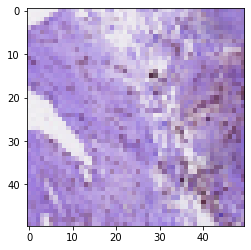

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(img_tensor[0])
plt.show()

In [10]:
from keras import models

# Extracts the outputs of the top 8 layers:
import tensorflow as tf

layer_outputs = []
layer_names = []
for layer in model.layers[1:]:
    
    try: 
        layer_outputs.append(layer.get_output_at(1))
        layer_names.append(layer.name)
    
    except:
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activation_model

In [11]:
layer_names

['block1_conv1',
 'block1_conv2',
 'conv_block',
 'conv_block_1',
 'conv_block_2',
 'flatten',
 'dropout',
 'F6',
 'Output']

In [26]:
model.get_layer('block1_conv1')

In [25]:
model.get_layer('conv_block')

In [12]:
# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)

In [13]:
print(len(activations))
print(len(layer_names))

9
9


In [14]:
first_layer_activation = activations[4]
print(first_layer_activation.shape)
first_layer_activation.shape[3]

(1, 6, 6, 120)


120

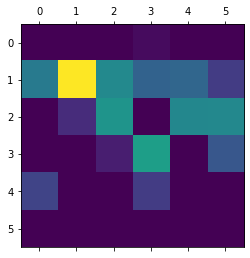

In [15]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 1], cmap='viridis')
plt.show()

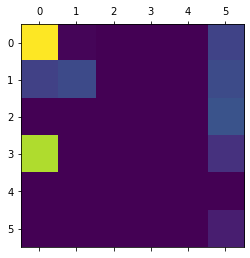

In [16]:
plt.matshow(first_layer_activation[0,:, :, 5], cmap='viridis')
plt.show()

In [17]:
activ = first_layer_activation[0,:, :, 5]

In [18]:
f_min, f_max = activ.min(), activ.max()
filters = (activ - f_min) / (f_max - f_min) 

In [19]:
filters.max()

1.0

In [20]:
import math
def plot_filters(activation_layer, layer_name, counter):

    n = int(np.sqrt(activation_layer.shape[3]))

    if int(n + 0.5) ** 2 == activation_layer.shape[3]:

        m = n
    else:
        m = math.ceil(activation_layer.shape[3] / n)

    fig, ax = plt.subplots(n, m, sharex='col', sharey='row',figsize=(15, 15))
    fig.suptitle(layer_name)
    
    filter_counter = 0
    for i in range(n):
        for j in range(m):
            ax[i, j].imshow(activation_layer[0,:, :, filter_counter], cmap='viridis')
            filter_counter += 1
    
    fig.savefig('img/activations/{}_activations_{}.png'.format(counter, layer_name))
    return None

In [22]:
for activation, name in zip(activations[:-4], layer_names[:-4]):
    print(name)
    print(activation.shape)
    

block1_conv1
(1, 50, 50, 64)
block1_conv2
(1, 50, 50, 64)
conv_block
(1, 25, 25, 6)
conv_block_1
(1, 12, 12, 16)
conv_block_2
(1, 6, 6, 120)


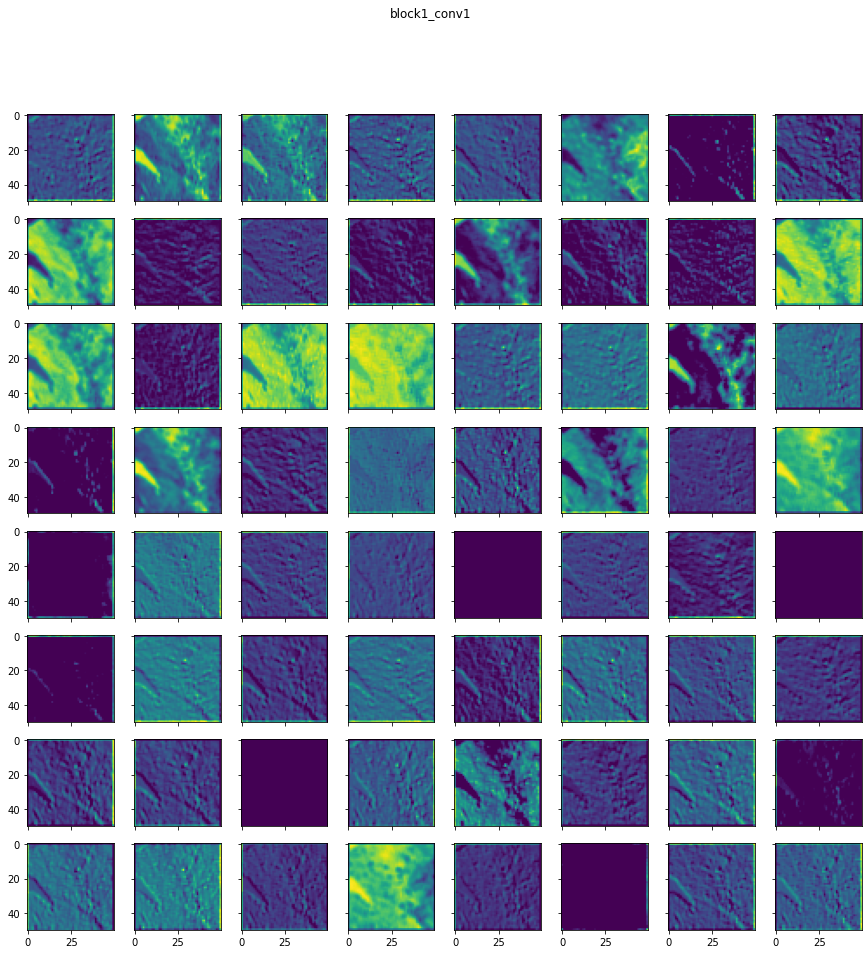

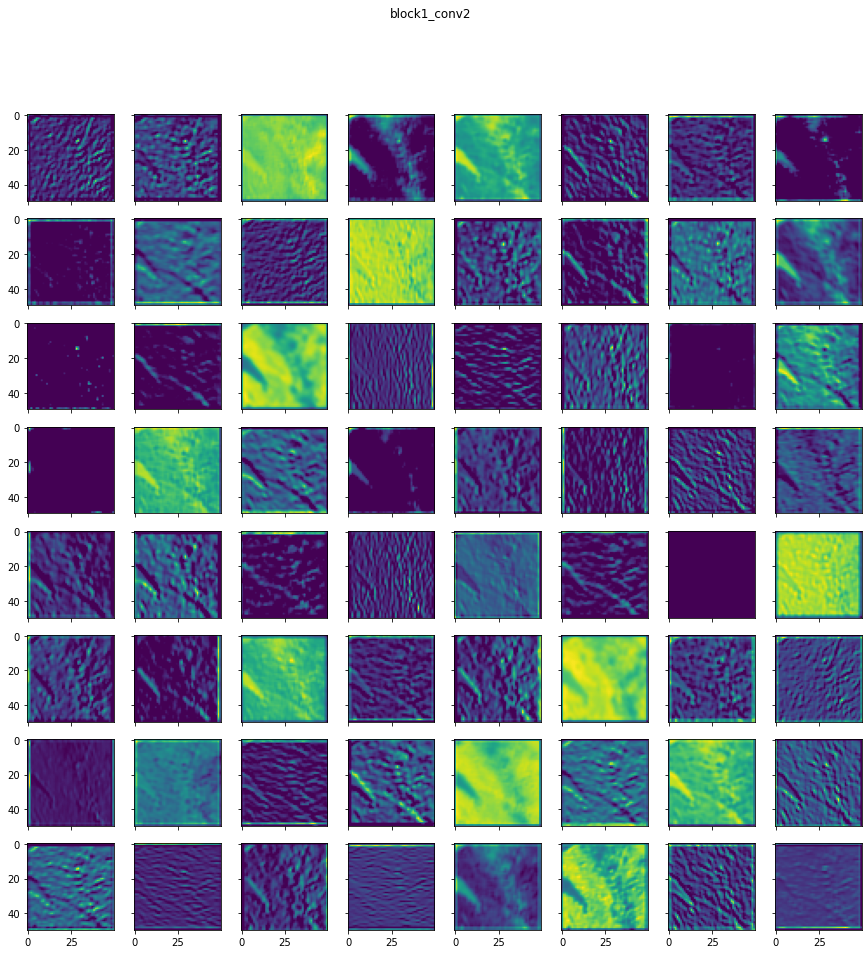

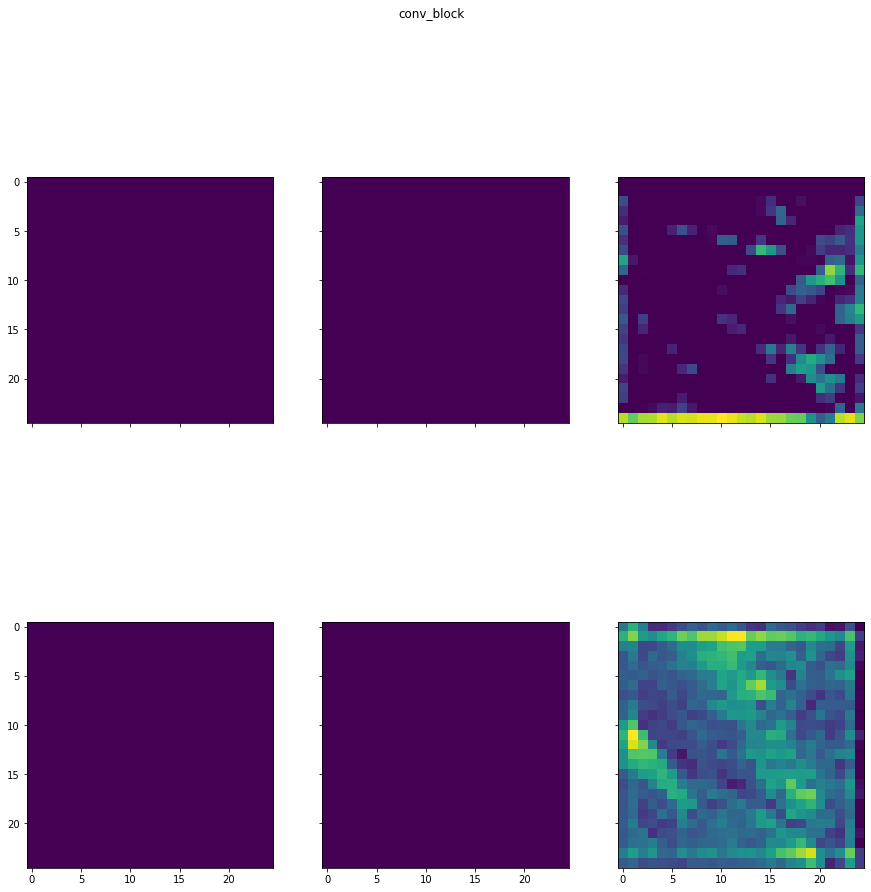

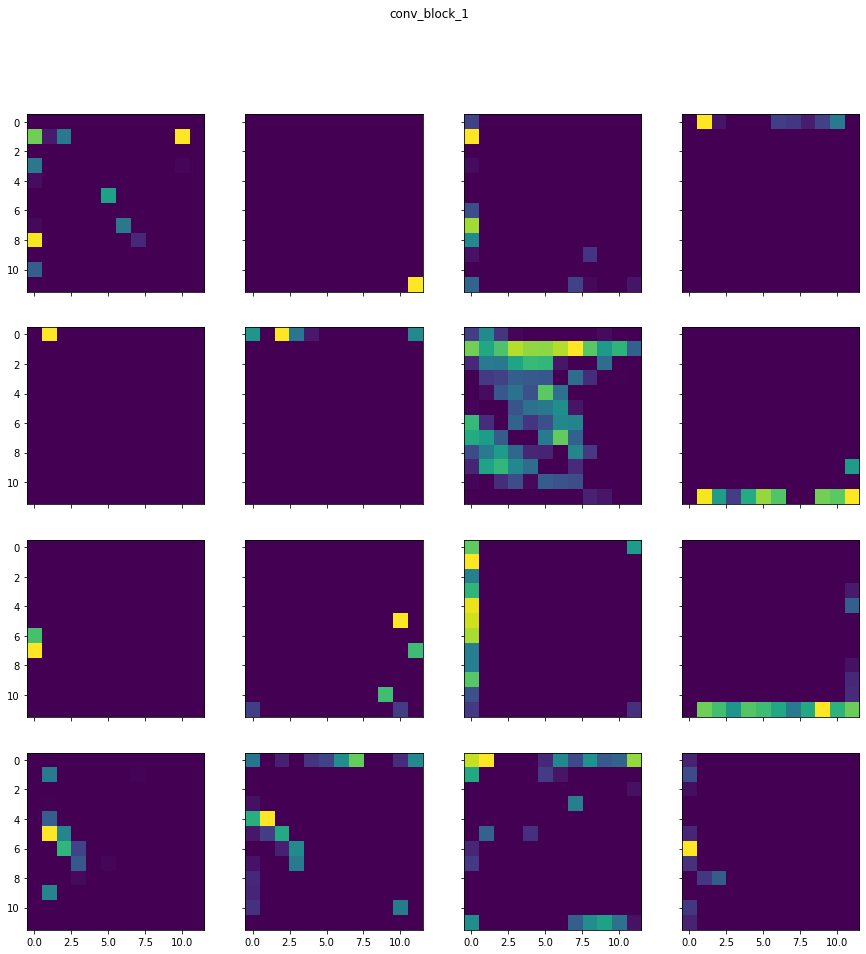

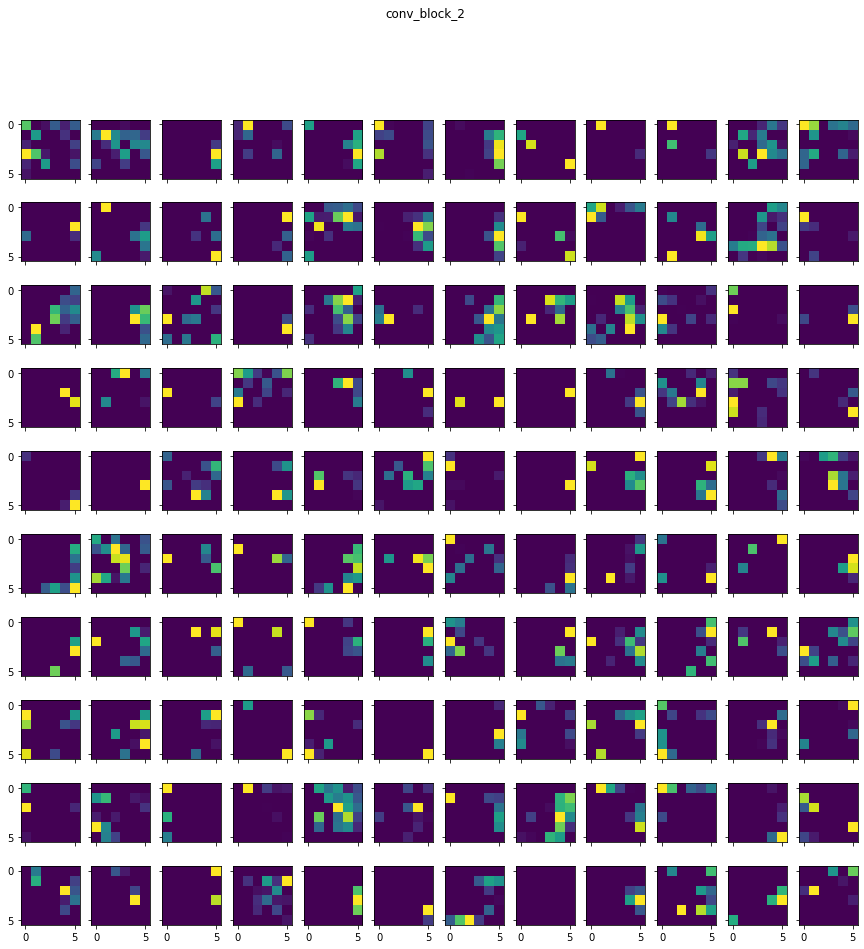

In [23]:
for counter, (activation, name) in enumerate(zip(activations[:-4], layer_names[:-4])):
    plot_filters(activation, name, counter)

In [50]:
import tensorflow as tf
#from d2l import tensorflow as d2l


def vgg_block(num_convs, num_channels):
    blk = keras.Model()
    for _ in range(num_convs):
        blk.add(tf.keras.layers.Conv2D(num_channels,kernel_size=3,
                                    padding='same',activation='relu'))
    blk.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
    return blk

In [29]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

In [51]:
input_shape = (50,50,3)

def vgg(input_shape):
   
    inputs = layers.Input(shape=input_shape,name='Input')
    x = vgg_block(1, 2)(inputs)
    outputs = layers.Dense(2)(x)
    net = keras.Model(inputs, outputs)
    return net

net = vgg(input_shape)

AttributeError: 'Model' object has no attribute 'add'

In [46]:
for layer in net.layers:
    print(layer.name)

Input
sequential_14
dense_6


In [47]:
net.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 50, 50, 3)]       0         
                                                                 
 sequential_14 (Sequential)  (None, 25, 25, 2)         56        
                                                                 
 dense_6 (Dense)             (None, 25, 25, 2)         6         
                                                                 
Total params: 62
Trainable params: 62
Non-trainable params: 0
_________________________________________________________________


In [49]:
net.get_layer('sequential_14')